### Preparation of reference data (Sofia)

[Map of reference data](https://gis.sofiaplan.bg:3344/webappbuilder/apps/50/) 

**Copy-pasting from `datasetrequirements.md`**:

## Reference data input requirements

If the extrinsic analysis is to be performed:  

- The reference datase must be a GeoPackage called `reference_data.gpkg`.  If a different file name or file extension is used, the file path in notebook 2a must be updated. The file must be in a format readable by [GeoPandas](https://geopandas.org/en/stable/docs/user_guide/io.html) (e.g., GeoPackage, GeoJSON, Shapefile etc.).  
- The reference dataset must be placed in the folder structure as follows: `/data/reference/'my_study_area'/raw/reference_data.gpkg`

For the code and the analysis to run without errors, the data must:

- ~~only contain **bicycle infrastructure** (i.e. not also the regular street network)~~
- ~~have all geometries as **LineStrings** (not MultiLineStrings)~~
- have **all intersections** represented as LineString endpoints (if nodes are missing at intersections, this will distort topology- and connectivity metrics)
- ~~be in a **CRS** recognized by GeoPandas~~
- ~~contain a column describing the **type of bicycle infrastructure**, i.e. whether each feature is a physically **protected**/separated infrastructure or if it is **unprotected** (*feature* refers to a network edge - each row in the network edge GeoDataFrames thus represents one feature)~~
- ~~contain a column describing whether each feature is **bidirectional** or not (see below for details)~~
- ~~contain a column describing how features have been digitized (**'geometry type'**) (see below for details)~~
- ~~contain a column with a unique **ID** for each feature~~

For an example of how a municipal dataset with bicycle infrastructure can be converted to the above format, see the notebooks [reference_data_preparation_01](scripts/examples/reference_data_preparation_01.ipynb) and [reference_data_preparation_02](scripts/examples/reference_data_preparation_02.ipynb) for workflows for preprocessing two different public Danish datasets on bicycle infrastructure.

## Run code below with different kernel/env (`qgis` needed),

**after**

1. filling out config file
2. running `python setup_folders.py` in terminal 

In [1]:
# import libraries
import requests
import os
os.environ["USE_PYGEOS"] = "0"
import geopandas as gpd
from qgis.core import *
import matplotlib.pyplot as plt
import contextily as cx
from collections import Counter
import osmnx as ox

**Show bounding polygon**

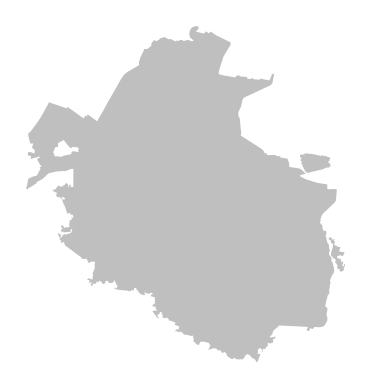

In [2]:
fig, ax = plt.subplots(1,1)
ox.geocode_to_gdf("Sofia, Bulgaria").plot(ax=ax, color = "grey", alpha = 0.5)
ax.set_axis_off()
fig.savefig("sofia-poly.png", dpi = 300)

**Define projected CRS**

In [3]:
proj_crs = "EPSG:7801"

**Get reference data**

In [4]:
# get data through API
my_url = "https://api.sofiaplan.bg/datasets/606?_ga=2.77331989.1611906718.1687181222-1368438426.1687181222"
gdf = gpd.read_file(requests.get(my_url).text)

# convert to projected CRS
assert gdf.crs is not None
gdf = gdf.to_crs(proj_crs)

# save to geojson format
gdf.to_file("refprep_raw.gpkg", index = False)

**Use ref data to create study area polygon**

In [5]:
study_area_polygon = gpd.GeoDataFrame(
    {
        "geometry": [gdf.unary_union.envelope]
    },
    crs = gdf.crs
    )

study_area_polygon.to_file(
    "../data/study_area_polygon/sofiaplan/study_area_polygon.gpkg", 
    index = False
    )

**Delete not needed columns**

In [6]:
gdf = gdf[["type", "posoka", "geometry"]]

**Check that the data set contains only bicycle infrastructure**

In [7]:
gdf.head(3)

,type,posoka,geometry
0,На тротоара споделена с пешеходци,Еднопосочна,"MULTILINESTRING ((317772.381 4728407.912, 3177..."
1,На тротоара споделена с пешеходци,Еднопосочна,"MULTILINESTRING ((317396.402 4727140.150, 3174..."
2,На тротоара споделена с пешеходци,Еднопосочна,"MULTILINESTRING ((326185.130 4724499.695, 3261..."


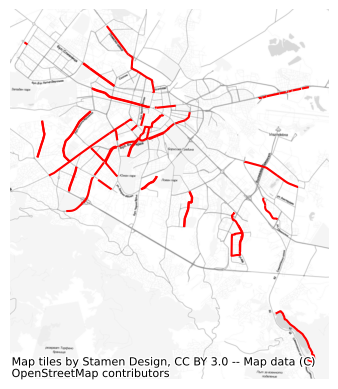

In [8]:
fig, ax = plt.subplots(1,1)
gdf.plot(ax=ax, color = "red")
cx.add_basemap(ax=ax, source = cx.providers.Stamen.TonerLite, crs = gdf.crs)
ax.set_axis_off()

**Make sure that all geometries are LineStrings**

In [9]:
gdf = gdf.explode(index_parts = False).reset_index(drop=True)

In [10]:
assert all(gdf.geometry.geom_type == "LineString")

**Check CRS**

In [11]:
# check crs
assert gdf.crs is not None
gdf.crs

<Derived Projected CRS: EPSG:7801>
Name: BGS2005 / CCS2005
Axis Info [cartesian]:
- x[north]: Northing (metre)
- y[east]: Easting (metre)
Area of Use:
- name: Bulgaria - onshore.
- bounds: (22.36, 41.24, 28.68, 44.23)
Coordinate Operation:
- name: Cadastral Coordinate System 2005
- method: Lambert Conic Conformal (2SP)
Datum: Bulgaria Geodetic System 2005
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

**Add column describing whether features are bidirectional**

In [12]:
Counter(gdf["posoka"])

Counter({'Еднопосочна': 69, 'Двупосочна': 37, None: 10})

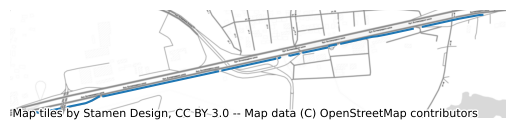

In [13]:
# Check the "None" ones
fig, ax = plt.subplots(1,1)
gdf[gdf["posoka"].isna()].plot(ax=ax)
cx.add_basemap(ax=ax, source = cx.providers.Stamen.TonerLite, crs = gdf.crs)
ax.set_axis_off()
# checked on google streetview >> is bidirectional

In [14]:
gdf["is_bidirectional"] = "unknown"
gdf.loc[gdf["posoka"]=='Двупосочна', "is_bidirectional"] = True
gdf.loc[gdf["posoka"]=="Еднопосочна", "is_bidirectional"] = False
gdf.loc[gdf["posoka"].isna(), "is_bidirectional"] = True

# drop "posoka" column (not needed anymore)
gdf.drop(columns = ["posoka"], inplace = True)

**Add column describing geometry type**

Centerline or true geometry? Since *all* the features are true geometries, we don't need a separate column - we just add `reference_geometries: true_geometries` in the config.yml file

**Add column describing type of bicycle infrastructure (protected/unprotected)**

In [15]:
# initiate column
gdf["protection"] = "unknown"

In [16]:
Counter(gdf["type"])

Counter({'На тротоара споделена с пешеходци': 29,
         'На пътното платно обособена': 23,
         'На тротоара обособена': 14,
         None: 10,
         'Контрафлоу': 1,
         'На пътното платно': 36,
         'На тротоара': 3})

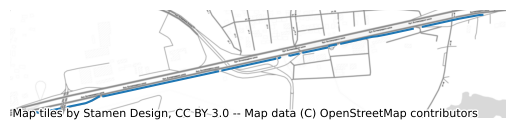

In [17]:
# Check the "None" ones
fig, ax = plt.subplots(1,1)
gdf[gdf["type"].isna()].plot(ax=ax)
cx.add_basemap(ax=ax, source = cx.providers.Stamen.TonerLite, crs = gdf.crs)
ax.set_axis_off()
# checked on google streetview >> looks protected

### Q: Does this count as "protected"?
<p align="left"><img src="prot01.png" width="75%" alt="Protected or not?"/></p>

### Decision: YES (На пътното платно обособена)

In [18]:
gdf.loc[gdf["type"]=="На тротоара споделена с пешеходци", "protection"] = "protected"
gdf.loc[gdf["type"]=="На пътното платно обособена", "protection"] = "protected" 
gdf.loc[gdf["type"]=="На тротоара обособена", "protection"] = "protected"
gdf.loc[gdf["type"].isna(), "protection"] = "protected"
gdf.loc[gdf["type"]=="Контрафлоу", "protection"] = "unprotected"
gdf.loc[gdf["type"]=="На пътното платно", "protection"] = "unprotected"
gdf.loc[gdf["type"]=="На тротоара", "protection"] = "protected"


In [19]:
Counter(gdf.protection)

Counter({'protected': 79, 'unprotected': 37})

In [20]:
# drop "type" column (not needed anymore)
gdf.drop(columns = ["type"], inplace = True)

**Save file for qgis input**

In [21]:
gdf.to_file("refprep_qgis_input.gpkg", index = False)
del(gdf)

**Make sure LineStrings end at intersections**
(with PyQGIS)

In [22]:
myprefix = '/Applications/QGIS-LTR.app/Contents/MacOS' # location of QGIS on your PC
myinput =  "refprep_qgis_input.gpkg" # input file
myoutput = "refprep_qgis_output.gpkg" # output file

In [23]:
# Supply path to qgis install location
QgsApplication.setPrefixPath(
    myprefix, 
    False # use default paths
    )

# Create a reference to the QgsApplication. 
qgs = QgsApplication(
    [], 
    False # do *not* use GUI
    )

# Load providers
qgs.initQgis()

qt.qpa.fonts: Populating font family aliases took 172 ms. Replace uses of missing font family "Open Sans" with one that exists to avoid this cost. 


In [24]:
# initialize Processing
import processing 
from processing.core.Processing import Processing
Processing.initialize()

In [25]:
# Run processing algorithm "split with lines"
temp_out_split = processing.run(
"native:splitwithlines",
    {
        'INPUT':myinput,
        'LINES':myinput,
        'OUTPUT':'TEMPORARY_OUTPUT'
    }
)

In [26]:
# delete "FID" column
mylayer = temp_out_split["OUTPUT"]
mylayer.dataProvider().deleteAttributes([0])
mylayer.updateFields()

In [27]:
# Check validity and only keep valid layer
temp_out_valid = processing.run(
    "qgis:checkvalidity",
        {
            'INPUT_LAYER': mylayer,
            'METHOD': 2,
            'IGNORE_RING_SELF_INTERSECTION': False,
            'VALID_OUTPUT': myoutput,
            'INVALID_OUTPUT':None,
            'ERROR_OUTPUT':None
        }
    )

Read back in the qgis-processed file

In [28]:
final_gdf = gpd.read_file(myoutput)

In [29]:
final_gdf = final_gdf.explode(index_parts = False)
assert (all(final_gdf.geometry.geom_type == "LineString"))

**Make sure that every feature has a unique ID**

In [30]:
final_gdf["unique_id"] = final_gdf.index

In [31]:
final_gdf.head()

,is_bidirectional,protection,geometry,unique_id
0,0,protected,"LINESTRING (317772.381 4728407.912, 317742.426...",0
1,0,protected,"LINESTRING (317396.402 4727140.150, 317408.334...",1
2,0,protected,"LINESTRING (326185.130 4724499.695, 326190.923...",2
3,0,protected,"LINESTRING (326280.313 4724835.208, 326243.152...",3
4,0,protected,"LINESTRING (317738.548 4728189.324, 317755.492...",4


In [32]:
Counter(final_gdf.protection)

Counter({'protected': 83, 'unprotected': 37})

In [33]:
Counter(final_gdf.is_bidirectional)

Counter({'0': 71, '1': 49})

In [34]:
# reformat string to bool
final_gdf.is_bidirectional = final_gdf.apply(
    lambda x:
    bool(x.is_bidirectional),
    axis = 1
)

In [35]:
final_gdf.head(3)

,is_bidirectional,protection,geometry,unique_id
0,True,protected,"LINESTRING (317772.381 4728407.912, 317742.426...",0
1,True,protected,"LINESTRING (317396.402 4727140.150, 317408.334...",1
2,True,protected,"LINESTRING (326185.130 4724499.695, 326190.923...",2


**Save to file/folder as required by BikeDNA**

In [36]:
final_gdf.to_file(
    "../data/REFERENCE/sofiaplan/raw/reference_data.gpkg", 
    index = False
    )